<a href="https://colab.research.google.com/github/Fatomk11295/Gene_expression_Analysis/blob/master/Gene_Expression_Analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This pipeline is a tutorial for junior bioinformaticians and students to help them gain hands-on experience with analyzing real gene expression data.**
Have fun learning :)

Download essential packages

In [ ]:
!pip install GEOparse

     |████████████████████████████████| 278 kB 4.1 MB/s 
  Created wheel for GEOparse: filename=GEOparse-2.0.3-py3-none-any.whl size=29065 sha256=240a83e22b9833424b4d6eec6a9cf301ff91ccf50f2b8a006e3213311a1e0f7b
  Stored in directory: /root/.cache/pip/wheels/4d/15/e8/fbf3b47444215d9728c20d7b35436b50086aa67c2ad6dcedad
Successfully built GEOparse


In [ ]:
import GEOparse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns

#Load the data

In [ ]:
#load the dataset with the ID GSE22552
gene = GEOparse.get_GEO(geo="GSE22552")

02-May-2022 12:58:57 DEBUG utils - Directory ./ already exists. Skipping.
02-May-2022 12:58:57 INFO GEOparse - File already exist: using local version.
02-May-2022 12:58:57 INFO GEOparse - Parsing ./GSE22552_family.soft.gz: 
02-May-2022 12:58:57 DEBUG GEOparse - DATABASE: GeoMiame
02-May-2022 12:58:57 DEBUG GEOparse - SERIES: GSE22552
02-May-2022 12:58:57 DEBUG GEOparse - PLATFORM: GPL570
/usr/local/lib/python3.7/dist-packages/GEOparse/GEOparse.py:545: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  table_data = parse_table_data(gpl_soft)
02-May-2022 12:58:59 DEBUG GEOparse - SAMPLE: GSM559689
02-May-2022 12:59:00 DEBUG GEOparse - SAMPLE: GSM559690
02-May-2022 12:59:00 DEBUG GEOparse - SAMPLE: GSM559691
02-May-2022 12:59:00 DEBUG GEOparse - SAMPLE: GSM559692
02-May-2022 12:59:00 DEBUG GEOparse - SAMPLE: GSM559693
02-May-2022 12:59:00 DEBUG GEOparse - SAMPLE: GSM559694
02-May-2022 12:59:00 DEBUG GEOparse - SAMPLE: GSM559695
02-May-202

In [ ]:
#Display the sample IDs (GSMs)
sampleID_List = [sample for sample, i in gene.gsms.items()]
sampleID_List

['GSM559689',
 'GSM559690',
 'GSM559691',
 'GSM559692',
 'GSM559693',
 'GSM559694',
 'GSM559695',
 'GSM559696',
 'GSM559697',
 'GSM559698',
 'GSM559699',
 'GSM559700',
 'GSM559701',
 'GSM559702',
 'GSM559703',
 'GSM559704']

In [ ]:
#Display the platform ID (GPLs)
platformID_list = [platfrom for platfrom, i in gene.gpls.items()]
platformID_list

['GPL570']

In [ ]:
#Concatenate the “VALUE” columns of the tables of all 16 samples of the dataset to form one single pandas dataframe.
gsmDataFrame = pd.concat([gene.gsms[gsm].table.set_index('ID_REF').rename(columns={'VALUE': gsm }) for gsm in sampleID_List],axis=1)
gsmDataFrame.head(5)

,GSM559689,GSM559690,GSM559691,GSM559692,GSM559693,GSM559694,GSM559695,GSM559696,GSM559697,GSM559698,GSM559699,GSM559700,GSM559701,GSM559702,GSM559703,GSM559704
ID_REF,,,,,,,,,,,,,,,,
1007_s_at,4.946777,4.728418,4.738051,4.762729,4.549447,4.835533,4.709747,4.715527,5.049346,5.631210,5.379607,5.397816,5.104329,4.912640,5.076418,5.181067
1053_at,8.207308,8.695805,8.383330,8.049325,8.751171,8.381886,7.992828,7.998183,7.401185,5.444929,5.151547,5.207811,7.819818,7.823374,7.262280,6.317741
117_at,6.311369,5.249919,5.953954,5.532214,5.746198,6.212243,6.870430,7.032106,7.295045,7.667298,7.784505,8.278446,5.672696,5.921971,6.699486,6.905009
121_at,7.159099,7.062484,7.329124,7.294014,7.006325,7.283475,7.156998,7.201767,7.397696,7.543862,7.869274,7.897521,7.164850,7.083180,7.217689,7.474255
1255_g_at,3.821799,3.603829,3.691750,3.791226,3.654054,3.681459,4.896534,4.008463,4.508532,4.946233,3.765626,4.096830,3.531186,3.668187,4.190600,3.905629


In [ ]:
#This table display information about the used probs (ID_REF)
probsDF = gene.gpls["GPL570"].table
probsDF_subset = probsDF[['ID','ENTREZ_GENE_ID','Gene Symbol']] #Subset the data to take out requiredd columns
probsDF_subset = probsDF_subset.rename(columns={'ID':'ID_REF'}) #Rename ID col to match the column in samplesDF
probsDF_subset = probsDF_subset.set_index('ID_REF') #Set ID_REF column as index

In [ ]:
#Merge the two columns “Gene Symbol” and “ENTREZ_GENE_ID” into the data DataFrame
mergedDF = gsmDataFrame.merge(probsDF_subset, left_index=True, how='left',right_index=True)
mergedDF.shape

(54675, 18)

In [ ]:
#Edit names/values in gene symbol column (remove anything after ///)
mergedDF['Gene Symbol'] = mergedDF['Gene Symbol'].apply(lambda row : str(row).split('/')[0].strip())
mergedDF['Gene Symbol']

ID_REF
1007_s_at            DDR1
1053_at              RFC2
117_at              HSPA6
121_at               PAX8
1255_g_at          GUCA1A
                    ...  
AFFX-ThrX-5_at        nan
AFFX-ThrX-M_at        nan
AFFX-TrpnX-3_at       nan
AFFX-TrpnX-5_at       nan
AFFX-TrpnX-M_at       nan
Name: Gene Symbol, Length: 54675, dtype: object

In [ ]:
#Edit names/values in ENTREZ_GENE_ID column (remove anything after ///)
mergedDF['ENTREZ_GENE_ID'] = mergedDF['ENTREZ_GENE_ID'].apply(lambda row : str(row).split('/')[0].strip())
mergedDF['ENTREZ_GENE_ID']

ID_REF
1007_s_at           780
1053_at            5982
117_at             3310
121_at             7849
1255_g_at          2978
                   ... 
AFFX-ThrX-5_at      nan
AFFX-ThrX-M_at      nan
AFFX-TrpnX-3_at     nan
AFFX-TrpnX-5_at     nan
AFFX-TrpnX-M_at     nan
Name: ENTREZ_GENE_ID, Length: 54675, dtype: object

In [ ]:
#Reset index
df_GEO = mergedDF.reset_index()

#Preprocessing 

In [ ]:
#Remove the four unsorted samples + unnecessary columns
df_GEO = df_GEO.drop(columns=['GSM559701','GSM559702','GSM559703','GSM559704','ENTREZ_GENE_ID','ID_REF'])

In [ ]:
#set gene symbol as index
df_GEO = df_GEO.set_index('Gene Symbol')

In [ ]:
#Calculate summary statistics for the gene expression values in the dataset
df_GEO.describe()

,GSM559689,GSM559690,GSM559691,GSM559692,GSM559693,GSM559694,GSM559695,GSM559696,GSM559697,GSM559698,GSM559699,GSM559700
count,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000
mean,5.631351,5.645538,5.647177,5.643353,5.650497,5.646240,5.647751,5.648663,5.642804,5.641746,5.632729,5.627669
std,2.008718,2.151832,2.135346,2.050417,2.132387,2.122161,2.103597,2.102086,2.093149,1.956583,1.967552,1.983168
min,2.552829,2.592396,2.557528,2.570300,2.590768,2.624404,2.589117,2.613913,2.625990,2.648773,2.624857,2.552459
25%,4.068560,3.935353,3.958457,4.037548,3.958517,3.972916,3.986983,3.989839,4.001895,4.130462,4.149201,4.119190
50%,5.234648,5.099071,5.140122,5.176868,5.138922,5.147776,5.166742,5.164457,5.171306,5.283507,5.255295,5.253193
75%,6.701256,6.920745,6.851461,6.774580,6.859045,6.843637,6.819665,6.812792,6.800105,6.644484,6.557022,6.596745
max,14.290997,14.424771,14.416912,14.270190,14.423644,14.405221,14.518687,14.520131,14.548121,14.698327,14.614120,14.627485


In [ ]:
#Are there any missing values in the data?
for col in df_GEO.columns:
  if df_GEO[str(col)].isna().sum() == 0:
    pass
  else :
    print(f'The {col} column has {df_GEO[str(col)].isna().sum()} missing values')

In [ ]:
#Calculate the skewness and kurtosis for each histogram
skewness_list = list(round(df_GEO.skew(),2))
kurtosis_list = list(round(df_GEO.kurt(),2))
col_list = list(df_GEO.columns)
title_list = list(zip(col_list,skewness_list,kurtosis_list))

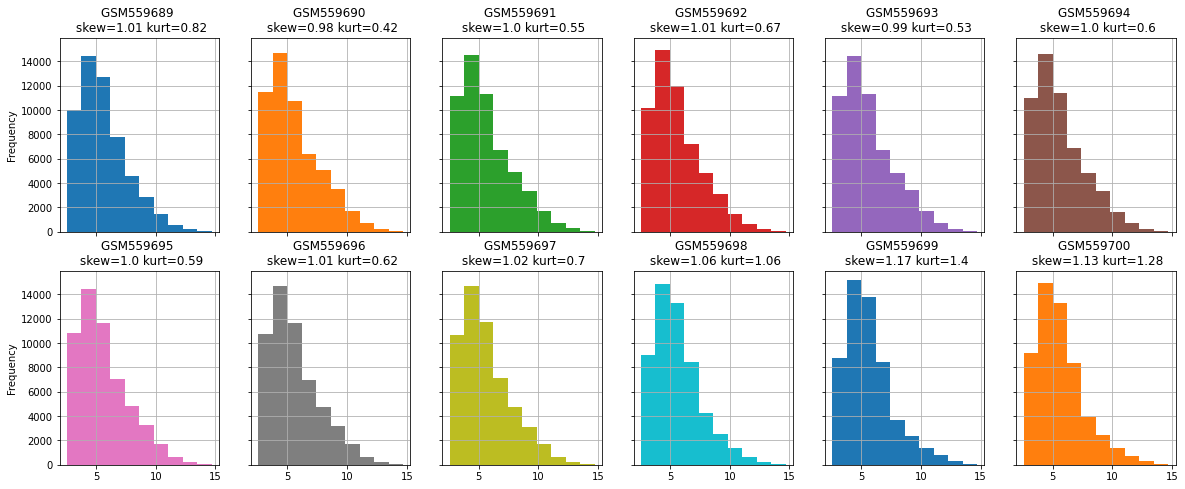

In [ ]:
#Plot histograms for the distribution of values in each one of the 12 samples
df_GEO.plot(kind='hist', subplots = True , figsize = (20,25) , sharex=True , layout = (6,6),
            title = [f'{x} \n skew={y} kurt={z}' for x,y,z in title_list] , 
            legend = False , sharey=True,
            grid=True)
plt.show()

Remove genes with expression less than 3.0 in 10 or more out of 12 samples

In [ ]:
#Remove genes with expression less than 6.0 in 10 or more out of 12 samples
#Count how many samples' gene expression value < 3 for each gene
filtered_dfGEO = df_GEO[(df_GEO < 6).sum(axis=1) < 10] 

In [ ]:
#Calculate summary statistics for the filtered dataset
filtered_dfGEO.describe()

,GSM559689,GSM559690,GSM559691,GSM559692,GSM559693,GSM559694,GSM559695,GSM559696,GSM559697,GSM559698,GSM559699,GSM559700
count,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000,22888.000000
mean,7.427279,7.669541,7.650221,7.550245,7.656153,7.643832,7.621696,7.614592,7.598402,7.367665,7.266349,7.317293
std,1.746560,1.764297,1.760375,1.706156,1.748826,1.739694,1.723180,1.736977,1.732495,1.733324,1.884421,1.842895
min,2.681277,2.861522,2.915748,2.734791,2.900518,3.090335,3.043126,3.199142,3.122728,2.701759,2.766366,2.826498
25%,6.203458,6.259329,6.260463,6.249882,6.265089,6.270470,6.260103,6.252756,6.253730,6.209733,6.093269,6.142186
50%,7.062255,7.397597,7.304621,7.195034,7.314202,7.280949,7.253982,7.248116,7.212076,6.969626,6.853884,6.898365
75%,8.439444,8.787769,8.738306,8.577970,8.749906,8.713083,8.684816,8.693445,8.633331,8.302457,8.263561,8.294555
max,14.290997,14.424771,14.416912,14.270190,14.423644,14.405221,14.518687,14.520131,14.548121,14.698327,14.614120,14.627485


In [ ]:
filtered_dfGEO.shape

(22888, 12)

In [ ]:
#Calculate the skewness and kurtosis for each histogram
skewness_Filteredlist = list(round(filtered_dfGEO.skew(),2))
kurtosis_Filteredlist = list(round(filtered_dfGEO.kurt(),2))
col_Filteredlist = list(filtered_dfGEO.columns)
title_Filteredlist = list(zip(col_Filteredlist,skewness_Filteredlist,kurtosis_Filteredlist))

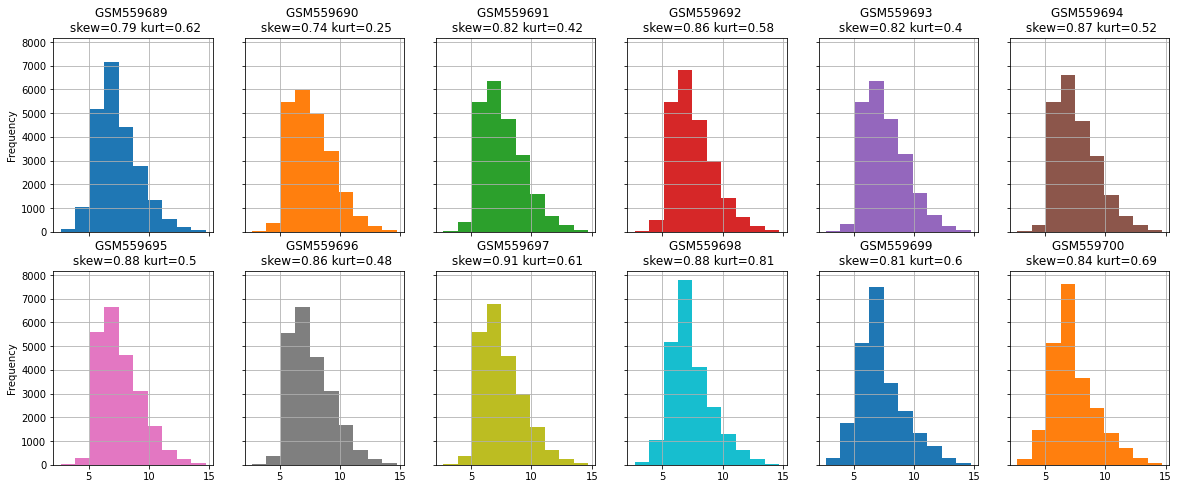

In [ ]:
#Plot histograms for the distribution of values in each one of the 12 samples from the filtered dataset
filtered_dfGEO.plot(kind='hist', subplots = True , figsize = (20,25) , sharex=True , layout = (6,6),
                    title = [f'{a} \n skew={b} kurt={c}' for a,b,c in title_Filteredlist] , legend = False , 
                    sharey=True, grid=True)
plt.show()

Step #2

Computing Quantile Normalization

In [ ]:
def quantile_normalize(df):
    """
    input: dataframe with numerical columns
    output: dataframe with quantile normalized values
    """
    #Calculate the mean (column-wise) then order the values (row-wise)
    sorted_points = np.mean(np.sort(df.values, axis=0), axis=1)
    #Return the index of sorted values (row-wise)
    original_index = np.argsort(np.argsort(df.values, axis=0), axis=0) 
    #Return orderd data frame with original index
    df_qn = pd.DataFrame(sorted_points[original_index], 
                          index=df.index, columns=df.columns)
    return(df_qn)

In [ ]:
dfGEO_quantile_normalize = quantile_normalize(filtered_dfGEO)

In [ ]:
dfGEO_quantile_normalize.head(5)

,GSM559689,GSM559690,GSM559691,GSM559692,GSM559693,GSM559694,GSM559695,GSM559696,GSM559697,GSM559698,GSM559699,GSM559700
Gene Symbol,,,,,,,,,,,,
RFC2,8.330009,8.467280,8.200765,8.023191,8.574865,8.236094,7.879539,7.884462,7.347321,5.561749,5.629677,5.570919
HSPA6,6.337888,5.063881,5.887775,5.372145,5.616857,6.165040,6.809179,6.961193,7.241866,7.938105,8.165327,8.560951
PAX8,7.272319,6.880690,7.185221,7.259656,6.897790,7.168203,7.077577,7.115236,7.343278,7.806482,8.242920,8.223294
MIR5193,7.393784,6.665198,7.170484,6.869859,6.809179,7.271648,7.094147,7.035806,7.867822,6.657103,6.674424,6.615545
THRA,6.231582,6.928323,6.628202,6.398474,6.566996,6.629586,7.193670,6.920523,6.944430,8.159312,8.400881,8.507887


Summarise probes that are linked to the same gene by using the median

In [ ]:
dfGEO_grouped = dfGEO_quantile_normalize.groupby(by = dfGEO_quantile_normalize.index).median()

In [ ]:
dfGEO_grouped.head(3)

,GSM559689,GSM559690,GSM559691,GSM559692,GSM559693,GSM559694,GSM559695,GSM559696,GSM559697,GSM559698,GSM559699,GSM559700
Gene Symbol,,,,,,,,,,,,
A1BG-AS1,6.408715,5.887568,6.143092,6.071564,6.180998,6.047779,6.137317,6.253656,6.206694,6.841918,6.742540,6.964423
A4GALT,7.533932,6.819932,7.289108,7.730130,7.374403,7.544729,7.224521,7.449622,7.448448,7.808789,8.036579,8.227588
AAAS,8.371522,7.069634,8.134411,8.389159,7.120892,8.082627,7.054450,7.104725,8.005995,7.391552,7.529362,7.211780


In [ ]:
print(f'Dataframe shape after summarizing the probes is {dfGEO_grouped.shape}')

Dataframe shape after summarizing the probes is (12230, 12)


#PCA analysis

In [ ]:
!pip install bioinfokit

In [ ]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler #For scaling the data before performing PCA
from bioinfokit.analys import get_data
import numpy as np

In [ ]:
#Standarize tha dataframe
#row-wise (standarize based on gene's mean and std)
#After standarization each gene mean value will be 0 and std 1
scaled_dfGEO =  StandardScaler().fit_transform(dfGEO_grouped.T) 
pd.DataFrame(dfGEO_grouped, columns=dfGEO_grouped.columns).head(5)

,GSM559689,GSM559690,GSM559691,GSM559692,GSM559693,GSM559694,GSM559695,GSM559696,GSM559697,GSM559698,GSM559699,GSM559700
Gene Symbol,,,,,,,,,,,,
A1BG-AS1,6.408715,5.887568,6.143092,6.071564,6.180998,6.047779,6.137317,6.253656,6.206694,6.841918,6.742540,6.964423
A4GALT,7.533932,6.819932,7.289108,7.730130,7.374403,7.544729,7.224521,7.449622,7.448448,7.808789,8.036579,8.227588
AAAS,8.371522,7.069634,8.134411,8.389159,7.120892,8.082627,7.054450,7.104725,8.005995,7.391552,7.529362,7.211780
AACS,7.450454,7.641720,7.545162,7.288778,7.447894,7.594145,7.210417,6.994446,7.604237,7.693780,7.074458,6.859110
AAED1,7.011493,6.440463,6.874267,6.713245,6.741055,6.198806,5.479762,5.627276,4.931474,5.331456,5.503702,5.346462


In [ ]:
scaled_dfGEO 

array([[ 0.25802468, -0.01867207,  1.46295064, ..., -0.29339726,
        -0.17593972, -1.18528515],
       [-1.32657504, -2.00356018, -1.078728  , ..., -0.52014499,
         1.50583569, -0.47561684],
       [-0.54963004, -0.6992718 ,  1.00003792, ..., -0.73333993,
         1.9485069 , -1.13571249],
       ...,
       [ 1.57522055,  0.74541971, -0.45024799, ...,  0.32452193,
         0.15393407,  0.68432001],
       [ 1.27305185,  1.37866556, -0.18120124, ...,  2.62195246,
        -0.06960137,  1.89031371],
       [ 1.94771081,  1.90966214, -0.80121579, ...,  0.74638923,
         0.80959014,  1.31643239]])

In [ ]:
#Perform PCA on scaled data
pca = PCA()
pca_out = pca.fit(scaled_dfGEO)

In [ ]:
#Generate coordingates for a PCA graph based on the loading scores
# and scaled data
pca_data = pca.transform(scaled_dfGEO)

Plot a scree plot to see how many principal components should go into the final plot

In [ ]:
#Calculate the percentage of variation that each principal components accounts for
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
#Create labels for the scree plot (one label per principal component)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)] 

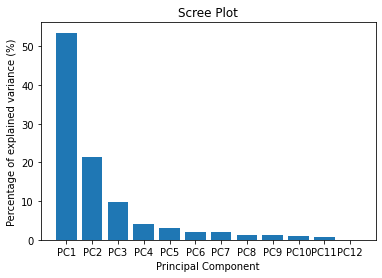

In [ ]:
#Plot the proportion of variation in each principal component
plt.bar( x = range(1, len(per_var) +1),
        height = per_var , tick_label = labels)
plt.ylabel('Percentage of explained variance (%)')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

Draw a PCA plot

In [ ]:
#Create a matrix for the pca data
pca_df = pd.DataFrame(pca_data , index = dfGEO_grouped.columns, #Rows have stages label
                      columns = labels) #Columns have PC labels
pca_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
GSM559689,-15.723331,93.695180,-42.948615,-19.116378,35.754460,-19.335862,4.343973,-2.264916,-2.069084,-4.570341,1.735446,-1.237415e-13
GSM559690,-83.741909,0.353295,49.243486,26.695988,4.814238,-14.877484,-9.325868,24.685982,1.256445,-12.537328,3.467801,1.834811e-13
GSM559691,-60.802473,44.743807,11.726879,6.528282,-21.302601,-16.504596,-8.342218,-5.074177,7.096499,26.667255,-8.085266,-3.809973e-14
GSM559692,-39.092481,52.952680,-26.271826,-8.311872,-8.682352,38.898984,1.277625,18.824386,1.673876,0.786439,-7.151376,-8.517839e-14
GSM559693,-74.091380,-4.410816,38.900256,10.018448,9.031870,10.736845,8.045621,-22.126878,-19.501017,-6.863951,-13.873252,1.661640e-13


In [ ]:
#Add stage label for each sample replicate
              #Assign the same value (stage) for multiple keys (samples)
stages_dict = {**dict.fromkeys(pca_df.index[:3], 'CFU-E'),
               **dict.fromkeys(pca_df.index[3:6], 'Pro-E'),
               **dict.fromkeys(pca_df.index[6:9], 'Int-E'),
               **dict.fromkeys(pca_df.index[9:12], 'Late-E')}

pca_df['Stages'] = pca_df.index.map(stages_dict) 

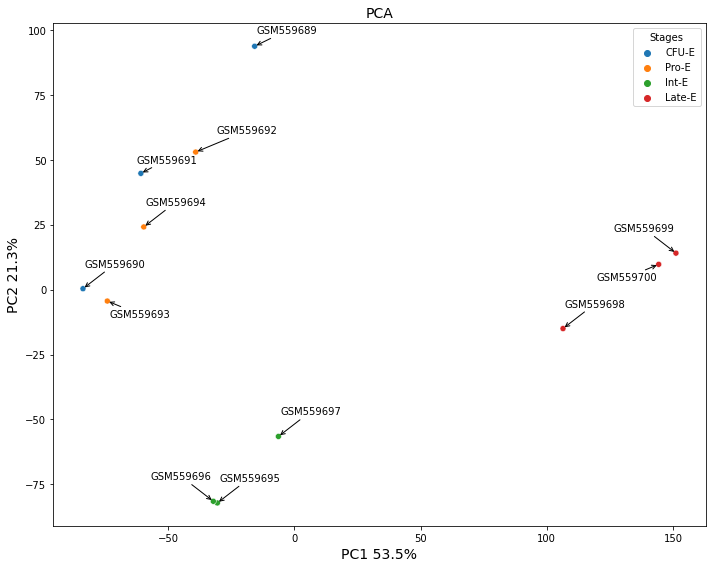

In [ ]:
#Plot scatter plot for PCA
plt.figure(figsize=(10,8))
sns.scatterplot( data = pca_df, x = 'PC1' , y='PC2', hue='Stages')
plt.title('PCA', fontsize=14)
plt.xlabel(f'PC1 {per_var[0]}%' , fontsize=14)
plt.ylabel(f'PC2 {per_var[1]}%' , fontsize=14)
#Add stages name to the graph
from adjustText import adjust_text
texts = []
for i,sample in enumerate(pca_df.index):
  texts.append(plt.annotate(sample,
               (pca_df.PC1.loc[sample],pca_df.PC2.loc[sample]),
               (pca_df.PC1.loc[sample],pca_df.PC2.loc[sample] +.3),
               arrowprops={'arrowstyle' : '->'}))
adjust_text(texts)
plt.tight_layout()
plt.show()

Check the loading scores for PC1 to determine which genes had the largest influence on separating the clusters (stages) along the x-axis.

In [ ]:
#Create a series object with the loading scores in PC1
loading_scores = pd.Series(pca.components_[0], index= dfGEO_grouped.index)
loading_scores

Gene Symbol
A1BG-AS1        0.011715
A4GALT          0.010483
AAAS           -0.002070
AACS           -0.005704
AAED1          -0.007478
                  ...   
ZZEF1           0.007942
ZZZ3           -0.005246
hsa-let-7a-3    0.009750
mir-223        -0.000139
nan             0.009876
Length: 12230, dtype: float64

In [ ]:
#Sort the loading scores based on their magnitude (absolute value)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
#Subset the top 10 indexes
top_10_genes = sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_genes])

Gene Symbol
ARRDC2      0.012317
OMA1       -0.012313
C6orf203   -0.012303
METTL2A    -0.012293
AASDHPPT   -0.012290
SCRN3      -0.012290
MCTS1      -0.012290
AGPS       -0.012289
PSMA2      -0.012286
VPS45      -0.012276
dtype: float64


#Kmeans Clustering

In [ ]:
#Summarize the replicates based on median
dfGEO_grouped['CFU-E'] = dfGEO_grouped.iloc[:,:3].median(axis=1)
dfGEO_grouped['Pro-E'] = dfGEO_grouped.iloc[:,3:6].median(axis=1)
dfGEO_grouped['Int-E'] = dfGEO_grouped.iloc[:,6:9].median(axis=1)
dfGEO_grouped['Late-E'] = dfGEO_grouped.iloc[:,9:12].median(axis=1)

In [ ]:
summarize_dfGEO = dfGEO_grouped[['CFU-E','Pro-E','Int-E','Late-E']]

In [ ]:
summarize_dfGEO.head(2)

,CFU-E,Pro-E,Int-E,Late-E
Gene Symbol,,,,
A1BG-AS1,6.143092,6.071564,6.206694,6.841918
A4GALT,7.289108,7.544729,7.448448,8.036579


Calculate z-scores for rows

In [ ]:
#Calculate z-scores for rows (axis = 0)
from scipy.stats import zscore
scored_dfGEO = summarize_dfGEO.apply(zscore)
scored_dfGEO.head(5)

,CFU-E,Pro-E,Int-E,Late-E
Gene Symbol,,,,
A1BG-AS1,-0.877382,-0.912522,-0.761461,-0.372987
A4GALT,-0.163461,0.000843,0.003429,0.369886
AAAS,0.363128,0.334341,-0.208296,-0.031210
AACS,-0.003950,-0.059195,-0.143193,-0.228387
AAED1,-0.421890,-0.514679,-1.209232,-1.302903


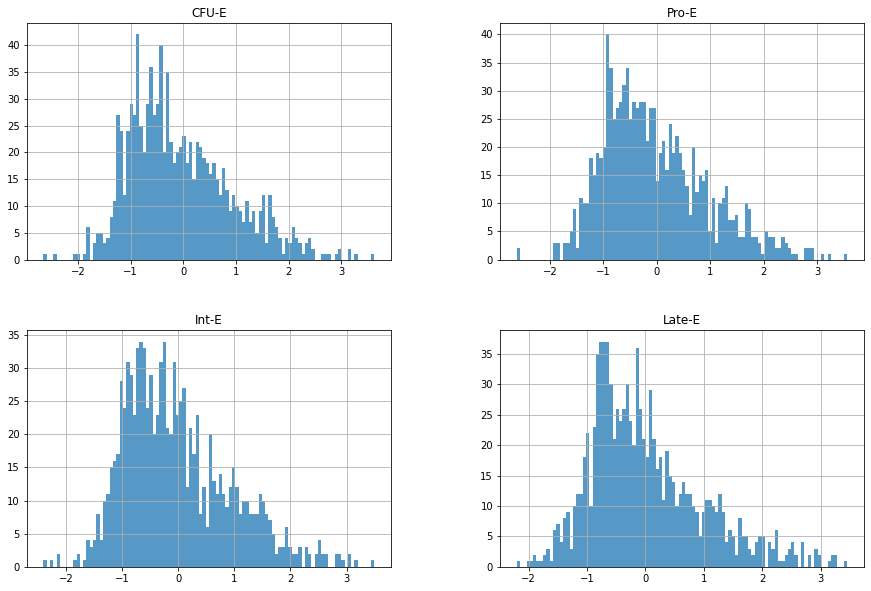

In [ ]:
#Plot the first 1000 genes data after z-score transformation
scored_dfGEO.iloc[:1000,:].hist(bins=100, figsize = (15,10) 
                                ,alpha=0.75)
plt.show()

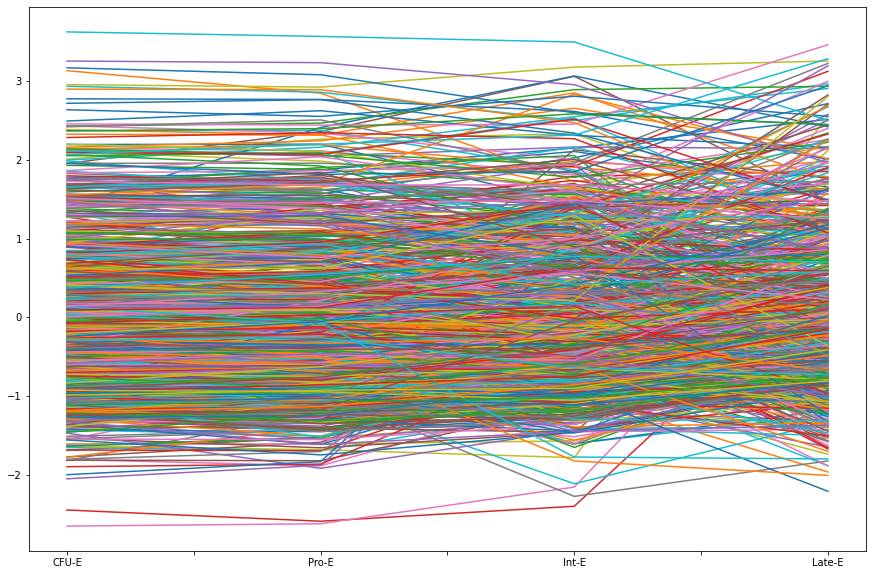

In [ ]:
scored_dfGEO.iloc[:1000].T.plot(figsize = (15,10),legend= False) 

Perform Kmeans clustering

In [ ]:
!pip install kneed

In [ ]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
#Instantiate the KMeans class 
kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=10,
    max_iter=300,
    random_state=42)

In [ ]:
#Fit the kmeans model to our standarized dataframe
#cluster them based on genes values (row wise)
y_predicted = kmeans.fit_predict(scored_dfGEO)
y_predicted

array([4, 3, 1, ..., 4, 4, 4], dtype=int32)

In [ ]:
#Add cluster number columns
scored_dfGEO['cluster']=y_predicted
scored_dfGEO.head()

,CFU-E,Pro-E,Int-E,Late-E,cluster
Gene Symbol,,,,,
A1BG-AS1,-0.877382,-0.912522,-0.761461,-0.372987,4
A4GALT,-0.163461,0.000843,0.003429,0.369886,3
AAAS,0.363128,0.334341,-0.208296,-0.031210,1
AACS,-0.003950,-0.059195,-0.143193,-0.228387,1
AAED1,-0.421890,-0.514679,-1.209232,-1.302903,4


In [ ]:
# The lowest SSE value
print(f'The lowest SSE value is {kmeans.inertia_}')
# Final locations of the centroid
print(f'Final locations of the centroid are {kmeans.cluster_centers_}')
# The number of iterations required to converge
print(f'The number of iterations required to converge is {kmeans.n_iter_}')

The lowest SSE value is 10386.44094044188
Final locations of the centroid are [[ 2.39598282  2.41688292  2.40436486  2.13440117]
 [ 0.25264869  0.23750135  0.03258671 -0.71287297]
 [ 1.07368989  1.09263128  1.07322994  0.83180737]
 [-0.17264836 -0.14809321  0.03931626  0.58718194]
 [-0.86840936 -0.88475863 -0.8657032  -0.61960231]]
The number of iterations required to converge is 26


Plot kmeans clusters

In [ ]:
#filter rows of original data
c1 = scored_dfGEO[scored_dfGEO.cluster == 0]
c2 = scored_dfGEO[scored_dfGEO.cluster == 1]
c3 = scored_dfGEO[scored_dfGEO.cluster == 2]
c4 = scored_dfGEO[scored_dfGEO.cluster == 3]
c5 = scored_dfGEO[scored_dfGEO.cluster == 4]

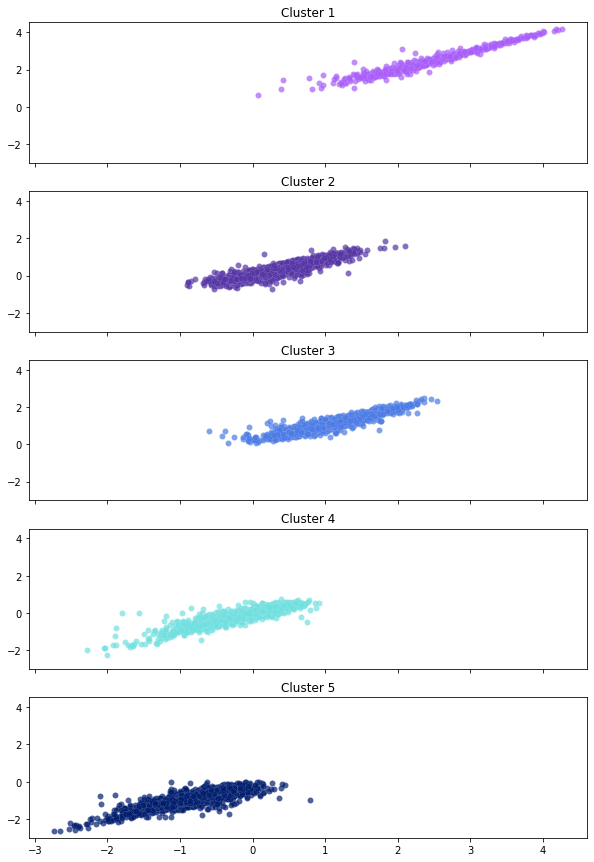

In [ ]:
#Plot each cluster separately in subplots
f,ax = plt.subplots(5,1, sharex=True, figsize=(10, 15),sharey=True)
cluster_list = [c1, c2, c3, c4, c5]
color_list = ['#A85CF9', '#5534A5', '#4B7BE5','#6FDFDF','#001D6E']
for i in range(5):
  ax[i].scatter(cluster_list[i].iloc[:,0] , cluster_list[i].iloc[:,1] , color = color_list[i],
                edgecolors = "white", linewidths = 0.1, alpha = 0.7)
  ax[i].set_title(f'Cluster {i+1}')

Plot all clusters together 

In [ ]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
scored_dfGEO['cen_x'] = scored_dfGEO.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
scored_dfGEO['cen_y'] = scored_dfGEO.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

In [ ]:
# define and map colors
colors = ['#EF4F4F', '#EE9595', '#FFCDA3','#74C7B8','#4B7BE5']
scored_dfGEO['c'] = scored_dfGEO.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],
                                              3:colors[3], 4:colors[4]})

In [ ]:
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D
import numpy as np
# create a list of legend elemntes
legend_elements = []
## markers / records
cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
## centroids
cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]
# add all elements to the same list
legend_elements.extend(cluster_leg)
legend_elements.extend(cent_leg)

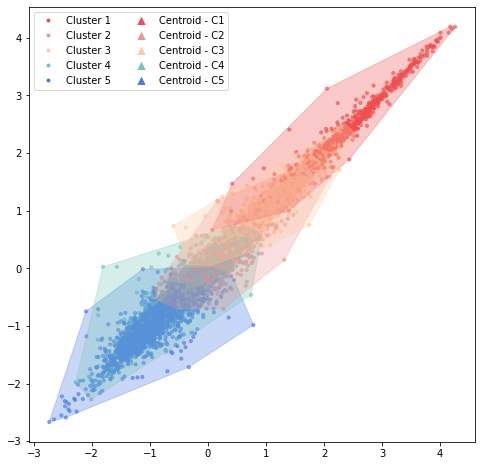

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(scored_dfGEO['CFU-E'], scored_dfGEO['Pro-E'], c=scored_dfGEO.c, alpha = 0.6, s=10)
# plot centers
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

# draw enclosure
for i in scored_dfGEO.cluster.unique():
    points = scored_dfGEO[scored_dfGEO.cluster == i][['CFU-E'	,'Pro-E']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])

# plot legend
plt.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()  

#GO Enrichment Analysis

Save cluster's genes in txt file to test GO enrichment using Panther

In [ ]:
#Write the genes of each cluster in a text file
clusters = [c1,c2,c3,c4,c5]
for c in range(len(clusters)):
  with open(f'Cluster_{c+1}.txt','w') as output:
    print(f'Cluster_{c+1} size is {len(clusters[c].index)}')
    for clust in clusters[c].index :
      output.write(f'{clust}\n')
    output.close()

Cluster_1 size is 661
Cluster_2 size is 2346
Cluster_3 size is 2154
Cluster_4 size is 2357
Cluster_5 size is 4712


Draw histogram to visualize gene expression distribution in each cluster during the 4 stages

<Figure size 360x360 with 0 Axes>

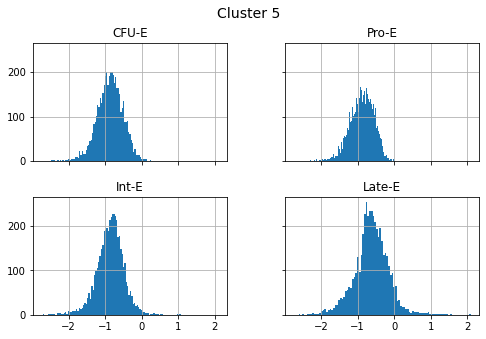

In [ ]:
plt.figure(figsize=(5,5))
c5.iloc[:,:-1].hist(figsize=(8,5),sharex=True,sharey=True,bins=100)
plt.suptitle("Cluster 5",fontsize=14)
plt.show()

In [ ]:
c5.describe()

,CFU-E,Pro-E,Int-E,Late-E,cluster
count,4712.000000,4712.000000,4712.000000,4712.000000,4712.0
mean,-0.868210,-0.884556,-0.865602,-0.619470,4.0
std,0.360433,0.341384,0.370946,0.465282,0.0
min,-2.732346,-2.667805,-2.703159,-2.612466,4.0
25%,-1.089269,-1.098567,-1.075062,-0.862847,4.0
50%,-0.857423,-0.857837,-0.845388,-0.617825,4.0
75%,-0.632357,-0.643413,-0.636061,-0.340754,4.0
max,0.784812,0.004295,1.068089,2.095200,4.0


Preprocess Enrichment analysis output files

In [ ]:
def concat_dataframe(bio,mol,cell):
  #Read dataframes
  bio_df = pd.read_csv(f'{bio}',delimiter='\t',skiprows=11)
  mol_df = pd.read_csv(f'{mol}',delimiter='\t',skiprows=11)
  cell_df = pd.read_csv(f'{cell}',delimiter='\t',skiprows=11)
  #Add lablel to each dataframe
  bio_df['GO'] = 'Biological process'


In [ ]:
bio_df = pd.read_csv('/content/drive/MyDrive/Bioinformatics Spe /Module I/Enrichment analysis/cluster4/c4_molecular.txt',delimiter='\t',skiprows=11)

In [ ]:
bio_df.columns

Index(['GO molecular function complete', 'Homo sapiens - REFLIST (20589)',
       'upload_1 (2160)', 'upload_1 (expected)', 'upload_1 (over/under)',
       'upload_1 (fold Enrichment)', 'upload_1 (raw P-value)',
       'upload_1 (FDR)'],
      dtype='object')

In [ ]:
bio_df.to_csv('c4_mol.csv')

In [ ]:
#Remove unclassified row
bio_df = bio_df.loc[bio_df['GO molecular function complete'] != 'Unclassified (UNCLASSIFIED)']

In [ ]:
#Top over represented GO term
sorted_bio_DF_Over = bio_df.sort_values(by='upload_1 (raw P-value)').loc[bio_df['upload_1 (over/under)'] == '+'].head(10)

In [ ]:
#Top under represented GO term
sorted_bio_DF_under = bio_df.sort_values(by='upload_1 (raw P-value)').loc[bio_df['upload_1 (over/under)'] == '-'].head(10)

In [ ]:
#Concate the dataframes
sorted_bio_DF = pd.concat([sorted_bio_DF_Over,sorted_bio_DF_under])

In [ ]:
#Rename column 
sorted_bio_DF.rename(columns = {'upload_1 (over/under)':'Level'}, inplace = True)
sorted_bio_DF['Level'].replace({'+':'Over','-':'Under'}, inplace = True)

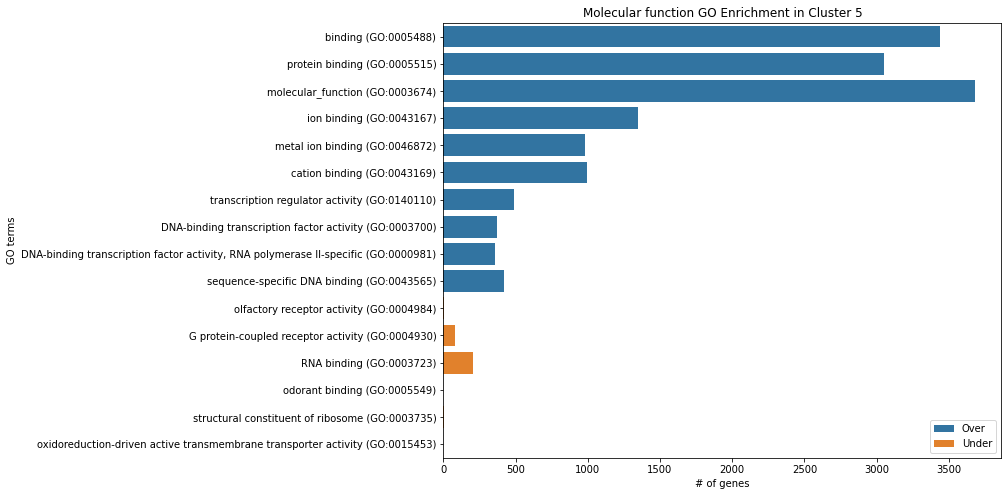

In [ ]:
#Plot the top 10 Enriched GO terms
p = plt.figure(figsize=(10,8))
p=sns.barplot(x='upload_1 (3929)', y='GO molecular function complete', 
              hue= 'Level', data =sorted_bio_DF,  dodge=False)
p.set_xlabel("# of genes")
p.set_ylabel("GO terms")
p.set_title("Molecular function GO Enrichment in Cluster 5")
plt.legend(loc='lower right')
plt.show()

In [ ]:
0.02 < 0.05

True